# Signal efficiencies

In [1]:
import itertools
import uproot
import awkward as ak
import numpy as np
import pandas as pd
from coffea import nanoevents
import vector
import math
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
import hist
from hist import Hist
from rich.table import Table
from rich.console import Console

In [2]:
matplotlib.rcParams.update({'figure.max_open_warning': 0})
plt.style.use(hep.style.CMS)

In [3]:
vector.register_awkward()

In [4]:
np.set_printoptions(suppress=True)

In [5]:
def inter_isolation(leptons_1, leptons_2, dR=1.6):
    """
    Compute the inter-isolation of each particle. It is supposed to work for one particle per event. The input is:
    - leptons_1: array of leptons for isolation calculation
    - leptons_2: array of all leptons in the events
    - dR: deltaR cut for isolation calculation
    """
    a, b = ak.unzip(ak.cartesian([leptons_1, leptons_2]))
    deltar_mask = a.deltaR(b) < dR
    return (ak.sum(b[deltar_mask].pt, axis=-1) - leptons_1.pt) / leptons_1.pt

def muon_filter(events, nMuons=4):
    """
    Filter events after the TripleMu trigger.
    Cleans muons and electrons.
    Requires at least nMuons with mediumId, pt, dxy, dz, and eta cuts.
    """
    muons = events.Muon
    electrons = events.Electron
    clean_muons = (
        (events.Muon.mediumId)
        & (events.Muon.pt > 3)
        & (abs(events.Muon.eta) < 2.4)
        & (abs(events.Muon.dxy) <= 0.02)
        & (abs(events.Muon.dz) <= 0.1)
    )
    clean_electrons = (
        (events.Electron.mvaFall17V2noIso_WPL)
        & (events.Electron.pt > 3)
        & (
            abs(events.Electron.dxy)
            < 0.05 + 0.05 * (abs(events.Electron.eta) > 1.479)
        )
        & (
            abs(events.Electron.dz)
            < 0.10 + 0.10 * (abs(events.Electron.eta) > 1.479)
        )
        & ((abs(events.Electron.eta) < 1.444) | (abs(events.Electron.eta) > 1.566))
        & (abs(events.Electron.eta) < 2.5)
    )
    muons = muons[clean_muons]
    electrons = electrons[clean_electrons]
    select_by_muons = ak.num(muons, axis=-1) >= nMuons
    events = events[select_by_muons]
    muons = muons[select_by_muons]
    electrons = electrons[select_by_muons]
    return events, electrons, muons

In [6]:
lumi = 59817.406
xsec_125 = 45.2

In [7]:
# Some commone paths
xrd_path = 'root://cmseos.fnal.gov//store/user/chpapage/SUEP_low_temp/2018/NANOAOD_merged/'
pre = "step_NANOAOD_ggH-channel_mMed-125"
dataset = lambda mD, temp, decay: f"{pre}_mDark-{mD}_temp-{temp}_decay-{decay}_13TeV-pythia8.root"

In [8]:
decays = ['darkPho']
scan_points = np.array(
    [
        [1, 0.25],
        [1, 0.5],
        [1, 1],
        [1, 2],
        [1, 4],
        [2, 0.5],
        [2, 1],
        [2, 2],
        [2, 4],
        [2, 8],
        [4, 1],
        [4, 2],
        [4, 4],
        [4, 8],
        [4, 16],
        [8, 2],
        [8, 4],
        [8, 8],
        [8, 16],
        [8, 32],
    ]
)
m_phi, temp = scan_points[:, 0], scan_points[:, 1]

decays_vs_mD = {
  "darkPho": [1, 2, 4, 8],
  #"darkPhoHad": [1.4, 2, 4, 8],
}
ratios = [0.25, 0.5, 1, 2, 4]

In [15]:
eff_5_3_3 = []
eff_10_5_5 = []
eff_or = []
eff_final = []
nElectron = []
ele_pt_sum = []
for decay, mDs in decays_vs_mD.items():
    for mD in mDs:
        for r in ratios:
            t = r * mD
            file = nanoevents.NanoEventsFactory.from_root(
                xrd_path + dataset(mD, t, decay).replace('.0', ''), 
                schemaclass=nanoevents.NanoAODSchema
            )
            events = file.events()
            name = f'mD-{mD}_T-{t}_{decay}'.replace('.0', '')
            print(f'Working on {name}')
            n_total = len(events)
            scale = lumi * xsec_125 / n_total
            eff_5_3_3.append(len(events[events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1])/n_total)
            eff_10_5_5.append(len(events[events.HLT.TripleMu_10_5_5_DZ == 1])/n_total)
            eff_or.append(
                len(
                    events[(events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1) | (events.HLT.TripleMu_10_5_5_DZ == 1)]
                )/n_total
            )
            
            # Continue with SR cuts
            events = events[(events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1) | (events.HLT.TripleMu_10_5_5_DZ == 1)]
            events, electrons, muons = muon_filter(events, nMuons=6)
            nElectron.append(ak.num(electrons, axis=-1))
            ele_pt_sum.append(ak.sum(electrons.pt, axis=-1))
            muonsCollection = ak.zip(
                {
                    "pt": events.Muon.pt,
                    "eta": events.Muon.eta,
                    "phi": events.Muon.phi,
                    "mass": events.Muon.mass,
                    "charge": events.Muon.pdgId / (-13),
                },
                with_name="Momentum4D",
            )
            SR_requirements = (
                inter_isolation(muonsCollection[:, 0], muonsCollection) > 1.0
            ) & (ak.mean(events.Muon.pt, axis=-1) < 15)
            events = events[SR_requirements]
            muons = muons[SR_requirements]
            eff_final.append(len(events)/n_total)

Working on mD-1_T-0.25_darkPho
Working on mD-1_T-0.5_darkPho
Working on mD-1_T-1_darkPho
Working on mD-1_T-2_darkPho
Working on mD-1_T-4_darkPho
Working on mD-2_T-0.5_darkPho
Working on mD-2_T-1_darkPho
Working on mD-2_T-2_darkPho
Working on mD-2_T-4_darkPho
Working on mD-2_T-8_darkPho
Working on mD-4_T-1_darkPho
Working on mD-4_T-2_darkPho
Working on mD-4_T-4_darkPho
Working on mD-4_T-8_darkPho
Working on mD-4_T-16_darkPho
Working on mD-8_T-2_darkPho
Working on mD-8_T-4_darkPho
Working on mD-8_T-8_darkPho
Working on mD-8_T-16_darkPho
Working on mD-8_T-32_darkPho


In [12]:
for i in nElectron:
    print(ak.mean(i))

0.5
0.0
0.4375
0.7165532879818595
0.9273242095327985
0.38
0.7464788732394366
0.9988649262202043
1.259644560034677
1.1875868457619267
1.0626506024096385
1.134020618556701
1.3108566581849024
1.2628267182962245
0.8708765315739868
1.2990654205607477
1.4203724819460282
1.2990338164251207
0.940952380952381
0.446


In [17]:
for i in ele_pt_sum:
    print(ak.mean(i))

5.354925632476807
0.0
4.3771443367004395
9.612712142148526
10.66425237435111
3.60177734375
8.723669490903756
11.646154050794552
14.748201804291288
17.093371859078278
12.724174039909638
12.790869644007731
15.592398218829517
18.62859806086641
15.90383850730443
14.095654753212617
17.352447382174077
20.236986714975846
17.206207217261905
10.011337890625


In [8]:
file = nanoevents.NanoEventsFactory.from_root(
    xrd_path + dataset(8, 8, 'darkPho').replace('.0', ''), 
    schemaclass=nanoevents.NanoAODSchema
)
events = file.events()

In [23]:
nElectron

[<Array [1, 0] type='2 * int64'>,
 <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='14 * int64'>,
 <Array [2, 1, 0, 0, 1, 1, ... 0, 0, 0, 0, 0, 0] type='64 * int64'>,
 <Array [0, 0, 0, 1, 0, 1, ... 0, 1, 0, 0, 0, 1] type='441 * int64'>,
 <Array [1, 1, 1, 1, 1, 0, ... 0, 1, 0, 2, 0, 2] type='2119 * int64'>,
 <Array [0, 0, 0, 0, 1, 0, ... 0, 0, 0, 0, 0, 1] type='50 * int64'>,
 <Array [3, 0, 4, 0, 4, 1, ... 1, 0, 0, 0, 0, 1] type='213 * int64'>,
 <Array [0, 0, 0, 0, 3, 0, ... 0, 2, 0, 0, 2, 1] type='881 * int64'>,
 <Array [2, 1, 1, 2, 1, 2, ... 3, 1, 5, 1, 1, 3] type='2307 * int64'>,
 <Array [2, 1, 1, 2, 0, 4, ... 0, 1, 1, 3, 0, 0] type='2159 * int64'>,
 <Array [1, 2, 0, 1, 1, 1, ... 0, 1, 2, 0, 1, 0] type='415 * int64'>,
 <Array [1, 0, 0, 2, 1, 0, ... 2, 0, 0, 0, 1, 2] type='1164 * int64'>,
 <Array [1, 4, 1, 0, 2, 0, ... 2, 3, 2, 3, 0, 2] type='2358 * int64'>,
 <Array [1, 1, 2, 2, 0, 1, ... 0, 2, 0, 2, 1, 1] type='2066 * int64'>,
 <Array [0, 0, 1, 1, 1, 0, ... 1, 1, 3, 0, 0, 0] type

In [9]:
ak.num(events.Electron[ak.num(events.Muon) >= 6])

<Array [4, 1, 5, 1, 3, 2, ... 3, 4, 1, 1, 1, 3] type='2666 * int64'>

In [ ]:
events.Lo

In [82]:
expected_stat_unc = []
total_mc_evts = 50000
for i in range(len(eff_or)):
    expected_stat_unc.append(np.sqrt(eff_final[i] * total_mc_evts) / (eff_final[i] * total_mc_evts))
    print(
        f"[{scan_points[i][0]:.0f}, {scan_points[i][1]:.2f}],"
        f"\t{eff_or[i]:.4f},\t{eff_final[i]:.4f},\t{expected_stat_unc[i]:.3f}"
    )

[1, 0.25],	0.0003,	0.0001,	0.447
[1, 0.50],	0.0018,	0.0012,	0.128
[1, 1.00],	0.0090,	0.0077,	0.051
[1, 2.00],	0.0781,	0.0513,	0.020
[1, 4.00],	0.3978,	0.2518,	0.009
[2, 0.50],	0.0061,	0.0055,	0.060
[2, 1.00],	0.0311,	0.0227,	0.030
[2, 2.00],	0.2034,	0.1160,	0.013
[2, 4.00],	0.4599,	0.2516,	0.009
[2, 8.00],	0.5158,	0.1882,	0.010
[4, 1.00],	0.0726,	0.0489,	0.020
[4, 2.00],	0.2682,	0.1505,	0.012
[4, 4.00],	0.4959,	0.2533,	0.009
[4, 8.00],	0.5071,	0.1788,	0.011
[4, 16.00],	0.4031,	0.0692,	0.017
[8, 2.00],	0.4217,	0.2534,	0.009
[8, 4.00],	0.5464,	0.2761,	0.009
[8, 8.00],	0.5220,	0.1747,	0.011
[8, 16.00],	0.4087,	0.0679,	0.017
[8, 32.00],	0.3081,	0.0194,	0.032


In [83]:
np.average(eff_final)

0.11941418367346941

In [84]:
np.median(expected_stat_unc)

0.015066002124896859

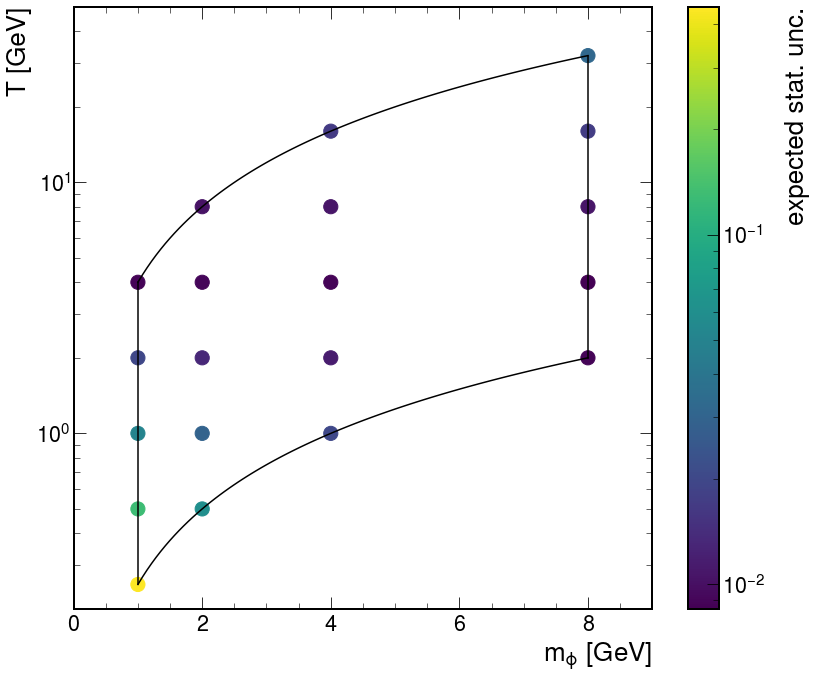

In [92]:
m_phi_space = lambda m_phi_max : np.linspace(1, m_phi_max, 100)
fig, ax = plt.subplots(1, figsize=(12, 10))
colors = np.array(expected_stat_unc)
sc = ax.scatter(m_phi, temp, c=colors, s=200, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(sc, ax=ax)
ax.plot(m_phi_space(8), 0.25 * m_phi_space(8), 'black')
ax.plot(m_phi_space(8), 4 * m_phi_space(8), 'black')
ax.plot([1, 1], [0.25, 4], 'black')
ax.plot([8, 8], [2, 32], 'black')
ax.set_yscale('log')
ax.set_xlim(0, 9)
ax.set_ylim(0.2, 50)
ax.set_xlabel(r'$m_{\phi}$ [GeV]')
ax.set_ylabel('T [GeV]')
cbar.set_label('expected stat. unc.', rotation=90, labelpad=20)
plt.tight_layout()

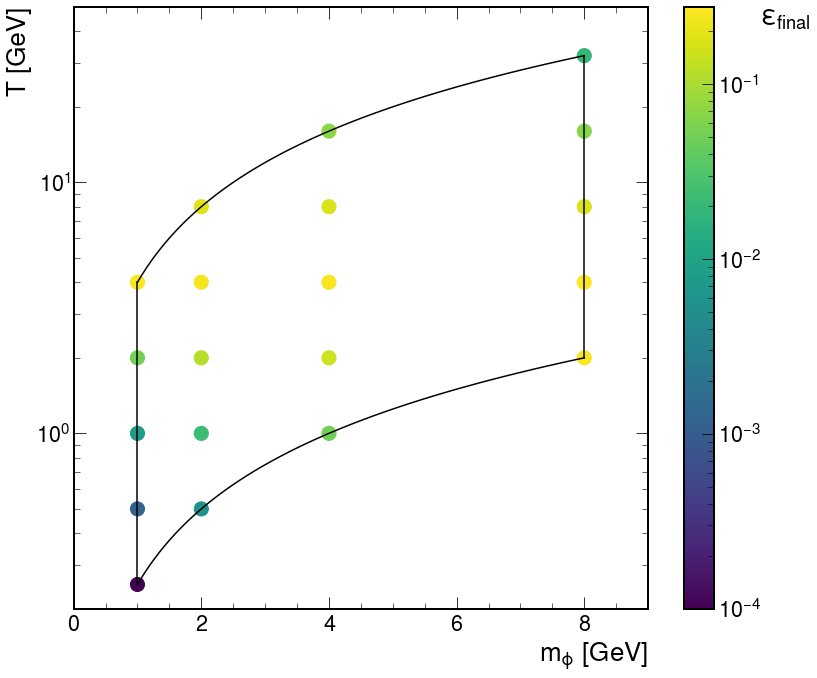

In [35]:
m_phi_space = lambda m_phi_max : np.linspace(1, m_phi_max, 100)
fig, ax = plt.subplots(1, figsize=(12, 10))
colors = np.array(eff_final)
sc = ax.scatter(m_phi, temp, c=colors, s=200, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(sc, ax=ax)
ax.plot(m_phi_space(8), 0.25 * m_phi_space(8), 'black')
ax.plot(m_phi_space(8), 4 * m_phi_space(8), 'black')
ax.plot([1, 1], [0.25, 4], 'black')
ax.plot([8, 8], [2, 32], 'black')
ax.set_yscale('log')
ax.set_xlim(0, 9)
ax.set_ylim(0.2, 50)
ax.set_xlabel(r'$m_{\phi}$ [GeV]')
ax.set_ylabel('T [GeV]')
cbar.set_label(r'$\epsilon_{final}$', rotation=0, labelpad=50)
plt.tight_layout()

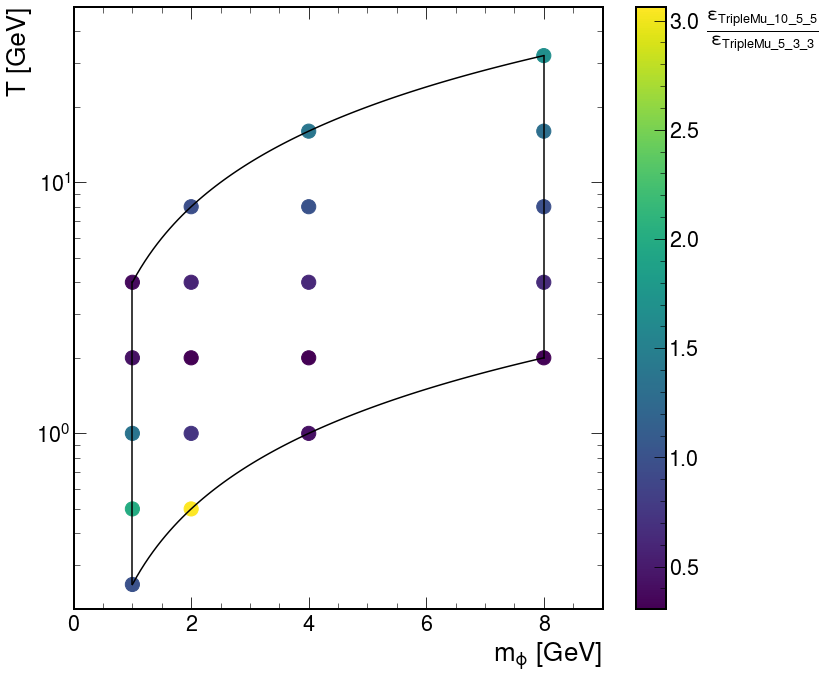

In [30]:
m_phi_space = lambda m_phi_max : np.linspace(1, m_phi_max, 100)
fig, ax = plt.subplots(1, figsize=(12, 10))
colors = np.array(eff_10_5_5) / np.array(eff_5_3_3)
sc = ax.scatter(m_phi, temp, c=colors, s=200)
cbar = plt.colorbar(sc, ax=ax)
ax.plot(m_phi_space(8), 0.25 * m_phi_space(8), 'black')
ax.plot(m_phi_space(8), 4 * m_phi_space(8), 'black')
ax.plot([1, 1], [0.25, 4], 'black')
ax.plot([8, 8], [2, 32], 'black')
ax.set_yscale('log')
ax.set_xlim(0, 9)
ax.set_ylim(0.2, 50)
ax.set_xlabel(r'$m_{\phi}$ [GeV]')
ax.set_ylabel('T [GeV]')
cbar.set_label(r'$\frac{\epsilon_{TripleMu\_10\_5\_5}}{\epsilon_{TripleMu\_5\_3\_3}}$', rotation=0, labelpad=120)
plt.tight_layout()

## Scan for m_S

In [98]:
# Some commone paths
xrd_path = 'root://cmseos.fnal.gov//store/user/chpapage/SUEP_signal_private/'
dataset = lambda mS, decay: f"SUEP-m{mS}-{decay}+RunIIAutumn18-private+MINIAODSIM.root"

In [99]:
decays = ['darkPho']
mS_arr = [125, 400, 750, 1000]
cutflows = {}
eff_5_3_3 = []
eff_10_5_5 = []
eff_or = []
eff_final = []
for decay in decays:
    for mS in mS_arr:
        file = nanoevents.NanoEventsFactory.from_root(
            xrd_path + dataset(mS, decay).replace('.0', ''), 
            schemaclass=nanoevents.NanoAODSchema
        )
        events = file.events()
        name = f'mS-{mS}_{decay}'.replace('.0', '')
        print(f'Working on {name}')
        n_total = len(events)
        eff_5_3_3.append(len(events[events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1])/n_total)
        eff_10_5_5.append(len(events[events.HLT.TripleMu_10_5_5_DZ == 1])/n_total)
        eff_or.append(
            len(
                events[(events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1) | (events.HLT.TripleMu_10_5_5_DZ == 1)]
            )/n_total
        )

        # Continue with SR cuts
        events = events[(events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1) | (events.HLT.TripleMu_10_5_5_DZ == 1)]
        muons = events.Muon
        events, muons = events[ak.num(muons) > 0], muons[ak.num(muons) > 0]
        clean_muons = (
            (events.Muon.mediumId)
            & (events.Muon.pt > 3)
            & (abs(events.Muon.eta) < 2.4)
            & (abs(events.Muon.dz) < 0.2)
        )
        clean_muons = clean_muons & (
            (abs(events.Muon.dxy) <= 0.02) & (abs(events.Muon.dz) <= 0.1)
        )
        muons = muons[clean_muons]
        select_by_muons_high = ak.num(muons, axis=-1) > 4
        select_by_muons_low = ak.num(muons, axis=-1) > 2
        events = events[select_by_muons_high & select_by_muons_low]
        muons = muons[select_by_muons_high & select_by_muons_low]
        muonsCollection = ak.zip(
            {
                "pt": events.Muon.pt,
                "eta": events.Muon.eta,
                "phi": events.Muon.phi,
                "mass": events.Muon.mass,
                "charge": events.Muon.pdgId / (-13),
            },
            with_name="Momentum4D",
        )
        SR_requirements = (
            inter_isolation(muonsCollection[:, 0], muonsCollection) > 1.0
        ) & (ak.mean(events.Muon.pt, axis=-1) < 15)
        events = events[SR_requirements]
        muons = muons[SR_requirements]
        eff_final.append(len(events)/n_total)

Working on mS-125_darkPho
Working on mS-400_darkPho
Working on mS-750_darkPho
Working on mS-1000_darkPho


In [102]:
expected_stat_unc = []
total_mc_evts = [50000, 25000, 20000, 20000]
for i in range(len(eff_or)):
    expected_stat_unc.append(np.sqrt(eff_final[i] * total_mc_evts[i]) / (eff_final[i] * total_mc_evts[i]))
    print(
        f"{mS_arr[i]:.0f},\t{eff_or[i]:.4f},\t{eff_final[i]:.4f},\t{expected_stat_unc[i]:.3f}"
    )

125,	0.2055,	0.1132,	0.013
400,	0.6955,	0.5471,	0.009
750,	0.9208,	0.8092,	0.008
1000,	0.9533,	0.8490,	0.008


Text(200, 0.02, '$m_\\phi$=2 GeV, T=2 GeV, leptonic decay')

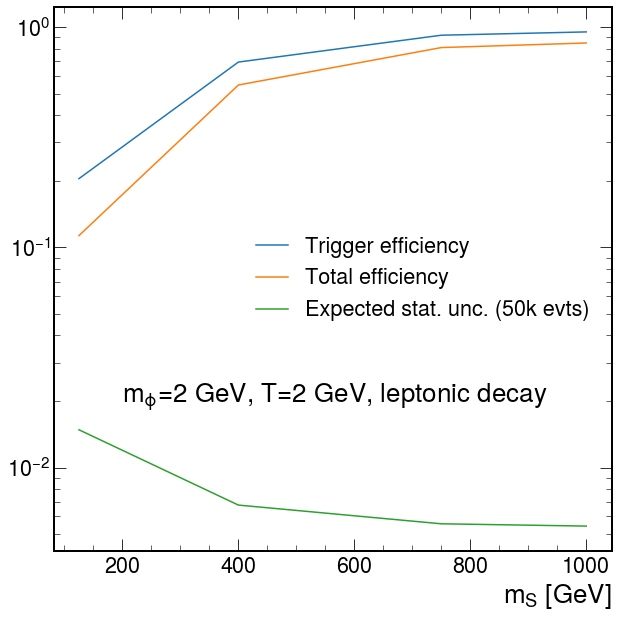

In [96]:
plt.plot(mS_arr, eff_or, label="Trigger efficiency")
plt.plot(mS_arr, eff_final, label="Total efficiency")
plt.plot(mS_arr, expected_stat_unc, label="Expected stat. unc. (50k evts)")
plt.yscale('log')
plt.xlabel(r"$m_S$ [GeV]")
plt.legend()
plt.text(200, 0.02, r"$m_\phi$=2 GeV, T=2 GeV, leptonic decay")